In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift

In [2]:
gpitch.amtgp.init_settings()
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [3]:
np.random.seed(30)
Nc = 5  # number of partials
var = 0.25*np.random.rand(Nc)  # variances
leng = 0.5*np.random.rand()  # lengthscales
f0 = 1000*np.random.rand()
freq = f0*np.asarray(range(1, Nc+ 1)) + np.sqrt(10.)*np.random.randn(Nc) # frequencies
kern1 = gpitch.kernels.MaternSpecMixSL(input_dim=1, lengthscales=leng, variances=var, frequencies=freq)
kern2 = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.025, variance=10.)

In [4]:
f0*np.asarray(range(1, Nc+ 1))

array([  991.75099229,  1983.50198459,  2975.25297688,  3967.00396917,
        4958.75496147])

In [5]:
print freq
print leng
print var

[  993.24011967  1978.89802976  2971.97538452  3966.16323068  4962.44612704]
0.17333092019
[ 0.16103588  0.09518712  0.16576198  0.04091268  0.24065195]


In [6]:
N, fs = 1600, 16e3
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)
Kcom = kern1.compute_K_symm(x)
Kact = kern2.compute_K_symm(x)

/home/pa/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


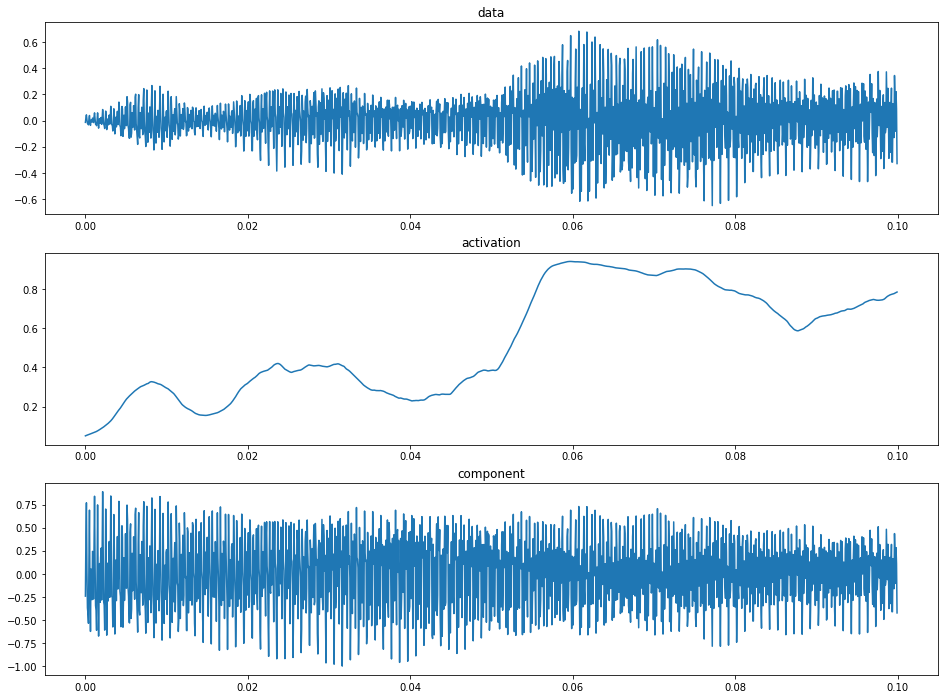

In [7]:
noise_var = 1e-5
com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)
com /= np.max(np.abs(com))
g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)
act = logistic(g)
y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y)
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com)

# New component covariance function

[ 0.16103588  0.09518712  0.16576198  0.04091268  0.24065195]


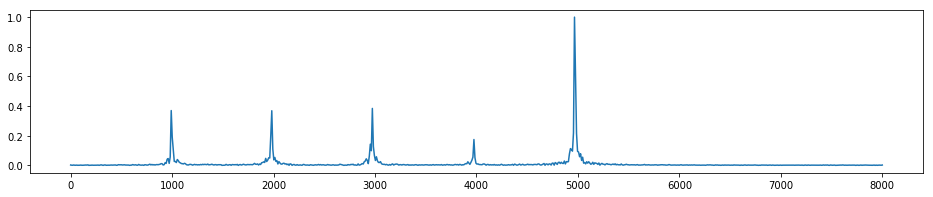

In [8]:
params, Y, S, F = gpitch.amtgp.init_com_params(y=y, fs=fs, Nh=Nc, scaled=True)
# print params[2]
# print params[1]
# print params[0]

print var

plt.figure()
plt.plot(F, S/np.max(np.abs(S)))

In [9]:
kern1

Name,values,prior,constraint
unnamed.frequency_1,[ 993.24011967],None,+ve
unnamed.frequency_2,[ 1978.89802976],None,+ve
unnamed.frequency_3,[ 2971.97538452],None,+ve
unnamed.frequency_4,[ 3966.16323068],None,+ve
unnamed.frequency_5,[ 4962.44612704],None,+ve
unnamed.lengthscales,[ 0.17333092],None,+ve
unnamed.variance_1,[ 0.16103588],None,+ve
unnamed.variance_2,[ 0.09518712],None,+ve
unnamed.variance_3,[ 0.16576198],None,+ve
unnamed.variance_4,[ 0.04091268],None,+ve


In [10]:
kern2

Name,values,prior,constraint
unnamed.lengthscales,[ 0.025],None,+ve
unnamed.variance,[ 10.],None,+ve


In [11]:
kern_com = gpitch.kernels.MaternSpecMixSL(input_dim=1, ideal_f0=f0, Nc=Nc)
kern_act = gpflow.kernels.Matern32(1)

In [12]:
ws, dec = N//2, 40  # samples per window, decimation factor
m = gpitch.modpdet.ModPDet(x=x, y=y, kern_com=kern_com, kern_act=kern_act, ws=ws, dec=dec, whiten=True)
m.model.kern1.fixed = False
m.model.kern2.fixed = False
m.model.likelihood.noise_var.fixed = False

In [13]:
maxiter, restarts = 500, 2
init_hyper, learnt_hyper, mse = m.optimize_restart(maxiter=maxiter, restarts=restarts)

| len: 0.1494, 0.0850 | sig: 11.1965, 10.4676 | noise_var: 0.0849, 0.0044 | var_4: 0.1632, 0.0209 |
| len: 0.7500, 0.1144 | sig: 13.7975, 12.9180 | noise_var: 0.0208, 0.0045 | var_4: 0.2342, 0.0216 |


In [14]:
#m.model.kern2.lengthscales = learnt_hyper[0].mean().copy()
#m.model.kern2.variance = learnt_hyper[1].mean().copy()
#m.model.likelihood.noise_var = learnt_hyper[2].mean().copy()


In [15]:
#m.optimize_windowed(disp=1, maxiter=500)

In [16]:
print freq
print leng
print var

[  993.24011967  1978.89802976  2971.97538452  3966.16323068  4962.44612704]
0.17333092019
[ 0.16103588  0.09518712  0.16576198  0.04091268  0.24065195]


In [17]:
m.model.kern1

Name,values,prior,constraint
kern1.frequency_1,[ 994.66332259],None,+ve
kern1.frequency_2,[ 1977.01798496],None,+ve
kern1.frequency_3,[ 2972.46235125],None,+ve
kern1.frequency_4,[ 3966.05422977],None,+ve
kern1.frequency_5,[ 4963.26970076],None,+ve
kern1.lengthscales,[ 0.09986642],None,"[0.0, 0.1]"
kern1.variance_1,[ 0.06282646],None,"[0.0, 0.25]"
kern1.variance_2,[ 0.06899216],None,"[0.0, 0.25]"
kern1.variance_3,[ 0.02925103],None,"[0.0, 0.25]"
kern1.variance_4,[ 0.02163188],None,"[0.0, 0.25]"


In [18]:
m.model.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 0.11438355],None,+ve
kern2.variance,[ 12.9180442],None,+ve


In [19]:
print m.model.likelihood.noise_var

noise_var transform:[0.0, 0.1] prior:None
[ 0.00448047]


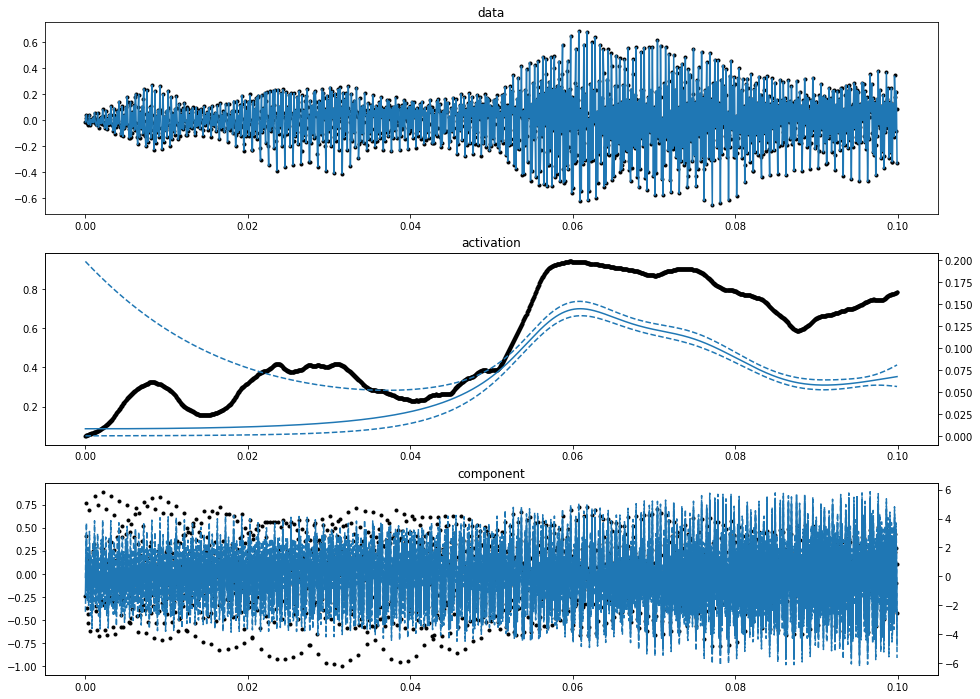

In [20]:
mean_f, var_f = m.model.predict_f(x)
mean_g, var_g = m.model.predict_g(x)
mean_act = logistic(mean_g)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.plot(x, y, '.k'), plt.title('data')
plt.plot(x, act*com)

plt.subplot(3,1,2)
plt.plot(x, act, '.k'), plt.title('activation')
plt.twinx()
plt.plot(x, mean_act)
plt.plot(x, logistic(mean_g + 2.*np.sqrt(var_g)), '--C0')
plt.plot(x, logistic(mean_g - 2.*np.sqrt(var_g)), '--C0')

plt.subplot(3,1,3)
plt.plot(x, com, '.k'), plt.title('component')
plt.twinx()
plt.plot(x, mean_f)
plt.plot(x, mean_f + 2.*np.sqrt(var_f), '--C0')
plt.plot(x, mean_f - 2.*np.sqrt(var_f), '--C0')

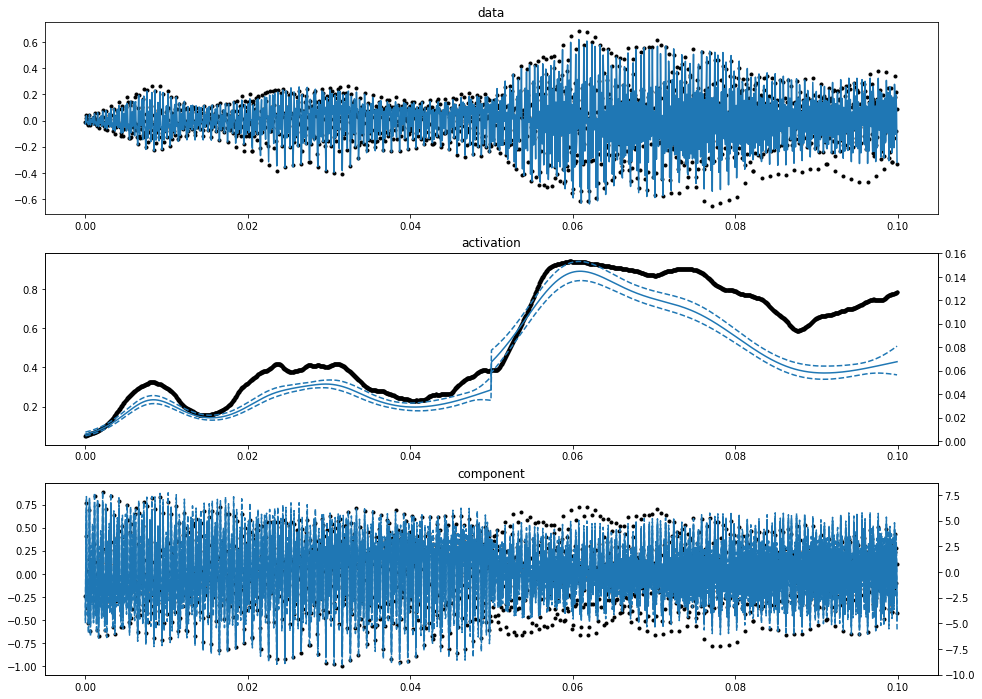

In [21]:
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.plot(x, y, '.k'), plt.title('data')
plt.plot(x, logistic(m.qm2)*m.qm1)

plt.subplot(3,1,2)
plt.plot(x, act, '.k'), plt.title('activation')
plt.twinx()
plt.plot(x, logistic(m.qm2))
plt.plot(x, logistic(m.qm2 + 2.*np.sqrt(m.qv2)), '--C0')
plt.plot(x, logistic(m.qm2 - 2.*np.sqrt(m.qv2)), '--C0')

plt.subplot(3,1,3)
plt.plot(x, com, '.k'), plt.title('component')
plt.twinx()
plt.plot(x, m.qm1)
plt.plot(x, m.qm1 + 2.*np.sqrt(m.qv1), '--C0')
plt.plot(x, m.qm1 - 2.*np.sqrt(m.qv1), '--C0')

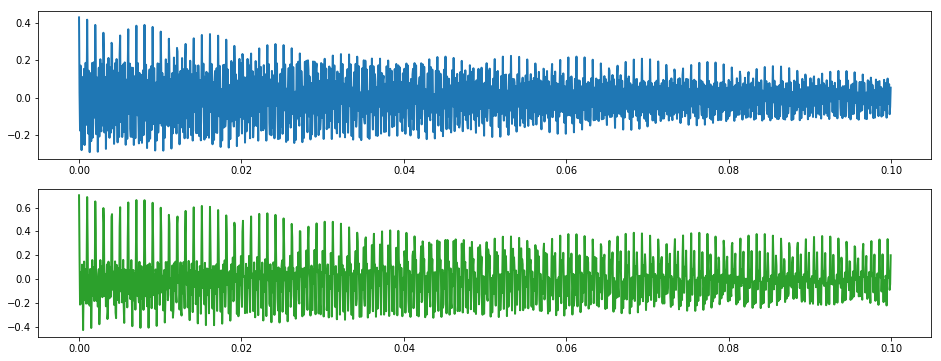

In [22]:
x_eval = x.copy()
k_plot_model = m.model.kern1.compute_K(x_eval, np.asarray(0.).reshape(-1,1))
k_plot_sample = kern1.compute_K(x_eval, np.asarray(0.).reshape(-1,1))

plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(x_eval, k_plot_model, lw=2)
#plt.xlim([0.0, 0.01])
plt.subplot(2,1,2)
plt.plot(x_eval, k_plot_sample, 'C2', lw=2)
#plt.legend(['k_new','k_old'])
#plt.xlim([0.0, 0.01])

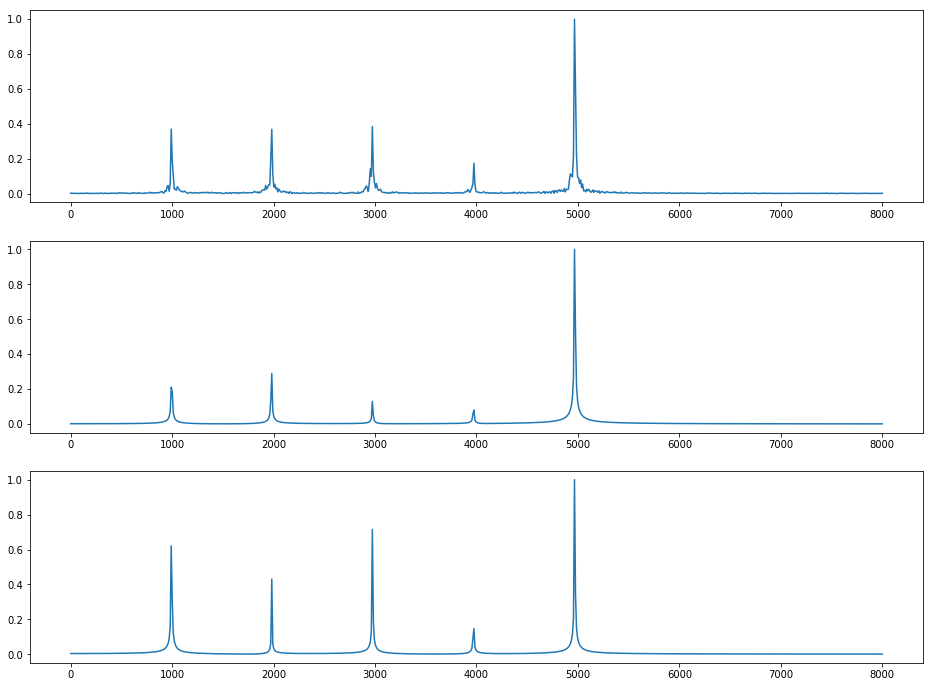

In [23]:
N = x_eval.size
Yk1 = fft(k_plot_model.reshape(-1,)) #  FFT data
Sk1 =  2./N * np.abs(Yk1[0:N//2]) #  spectral density data

Yk2 = fft(k_plot_sample.reshape(-1,)) #  FFT data
Sk2 =  2./N * np.abs(Yk2[0:N//2]) #  spectral density data

plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(F, S / np.max(np.abs(S)))
plt.subplot(3, 1, 2)
plt.plot(F, Sk1 / np.max(np.abs(Sk1)))
plt.subplot(3, 1, 3)
plt.plot(F, Sk2 / np.max(np.abs(Sk2)))